# Importar librerias

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/manuelavrestrepo/Monografia/main/init.py
import init
init.init(force_download=False);

replicating local resources


In [2]:
!pip install netCDF4
!pip install python-dotenv
!pip install cartopy

In [4]:
# Librerías para manipulación y visualización de datos geoespaciales
import numpy as np
import pandas as pd
import xarray as xr
import geopandas

# Librerías para trabajo con archivos NetCDF y datos climáticos
from netCDF4 import Dataset
import xarray as xr

# Librerías para visualización de mapas y gráficos
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.img_tiles as cimgt
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

# Librerías para manipulación de fechas y tiempo
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date

# Librerías para procesamiento y análisis de datos espaciales
from scipy import spatial
from shapely.geometry import mapping
import shapely.geometry as sgeom
from shapely.geometry import Point, Polygon

# Librerías para manipulación de archivos y variables de entorno
import os
from dotenv import load_dotenv

# Librerías para visualización de datos en formato shapefile
import shapefile as shp

# Funciones

In [5]:
# Define una función para redondear un valor al múltiplo más cercano
def myround(x, base=100):
    return base * round(x / base)

# Define funciones para configurar las características del mapa
def setup_map(ax):
    ax.set_extent([-79, -66.9, -4.2, 12.5], ccrs.PlateCarree(central_longitude=0, globe=None))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
    shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    ax.add_geometries(reader.geometries(), crs=ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='None', edgecolor='dimgray', linewidths=0.8, alpha=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='dimgray', alpha=0.7, linewidth=0.2)


# Datos

## Datos de precipitación de CHIRPS

### Ejemplo sobre una muestra de dos años de la información

In [6]:
# Abrir uno de los archivos NetCDF para extraer los valores de latitud y longitud
Variable = Dataset('/content/local/DatosCrudos/PCP/COL_1981_CHIRPS.nc', 'r')
lat_values_CHIRPS = np.array(Variable.variables['latitude'][:])
lon_values_CHIRPS = np.array(Variable.variables['longitude'][:])

# Definir los valores de latitud y longitud para la región de estudio (Colombia)
lat_min_region_estudio = -5
lat_max_region_estudio = 15
lon_min_region_estudio = -80
lon_max_region_estudio = -65

# Filtrar los valores de latitud y longitud dentro de la región de estudio
Pos_Lat = np.where((lat_values_CHIRPS >= lat_min_region_estudio) & (lat_values_CHIRPS <= lat_max_region_estudio))[0]
Pos_Lon = np.where((lon_values_CHIRPS >= lon_min_region_estudio) & (lon_values_CHIRPS <= lon_max_region_estudio))[0]
lat_values_CHIRPS = lat_values_CHIRPS[Pos_Lat]
lon_values_CHIRPS = lon_values_CHIRPS[Pos_Lon]


# Abre y combina múltiples archivos NetCDF en un solo conjunto de datos usando xarray
ncfiles1 = r'/content/local/DatosCrudos/PCP/COL_*'
# Especifica los archivos NetCDF a abrir utilizando una máscara para unicamente guardar en la variable ds1 la región de estudio
ds1 = xr.open_mfdataset(ncfiles1).interp(longitude=lon_values_CHIRPS, latitude=lat_values_CHIRPS)


In [7]:
# ds1 es un objeto xarray.Dataset. Que contiene información sobre las dimensiones, coordenadas, variables
# y atributos del conjunto de datos.
ds1

<xarray.Dataset>
Dimensions:    (time: 144, latitude: 400, longitude: 300)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-06 ... 1982-12-26
  * longitude  (longitude) float32 -79.98 -79.93 -79.88 ... -65.13 -65.08 -65.03
  * latitude   (latitude) float32 -4.975 -4.925 -4.875 ... 14.88 14.92 14.97
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(72, 400, 300), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-02-27
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given pentad.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [8]:
# Copiar los datos de la variable 'precip', generando una matriz tridimensional con 3024 registros de tiempo
# (acumulados de cada 5 días desde 1981 hasta 2023), en una región de estudio dividida en pixeles de tamaño 0.05° x 0.05°,
# lo que resulta en una resolución de 300 longitudes y 400 latitudes.
pcp = ds1['precip'].copy()
pcp

<xarray.DataArray 'precip' (time: 144, latitude: 400, longitude: 300)>
dask.array<transpose, shape=(144, 400, 300), dtype=float32, chunksize=(72, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-06 ... 1982-12-26
  * longitude  (longitude) float32 -79.98 -79.93 -79.88 ... -65.13 -65.08 -65.03
  * latitude   (latitude) float32 -4.975 -4.925 -4.875 ... 14.88 14.92 14.97
Attributes:
    units:               mm/pentad
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           pentad
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [9]:
# Eliminar la variable ds1 de la memoria, liberando así el espacio que ocupaba.
del ds1

### Precipitación mensual acumulada

In [12]:
# Re-muestrear los datos de precipitación para obtener matrices de la precipitación mensual acumulada (504 meses).
pcp_monthly = pcp.resample(time='M').sum('time')

# Guardar los datos de precipitación mensual acumulada en un archivo NetCDF en la ubicación especificada.
#pcp_monthly.to_netcdf('/content/local/ArchivosTransformados/pcp_monthly_sample.nc')

#Mostrar los datos de precipitación mensual acumulada para los dos años usados como muestra
pcp_monthly

<xarray.DataArray 'precip' (time: 24, latitude: 400, longitude: 300)>
dask.array<stack, shape=(24, 400, 300), dtype=float32, chunksize=(1, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -79.98 -79.93 -79.88 ... -65.13 -65.08 -65.03
  * latitude   (latitude) float32 -4.975 -4.925 -4.875 ... 14.88 14.92 14.97
  * time       (time) datetime64[ns] 1981-01-31 1981-02-28 ... 1982-12-31
Attributes:
    units:               mm/pentad
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           pentad
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [13]:
# Eliminar la variable pcp_monthly correspondiente a una muestra de dos años para liberar memoria.
del pcp_monthly

In [14]:
# Cargar una nueva variable pcp_monthly1 a partir 3 archivos NetCDF, segmentados por temas de memoria y los
# cuales contienen la serie mensual para la totalidad de los datos.
ncfiles2 = r'/content/local/DatosTransformados/pcp_monthly*'
# Abre y combina múltiples archivos NetCDF en un solo conjunto de datos usando xarray
pcp_monthly1 = xr.open_mfdataset(ncfiles2).interp(longitude=lon_values_CHIRPS, latitude=lat_values_CHIRPS)

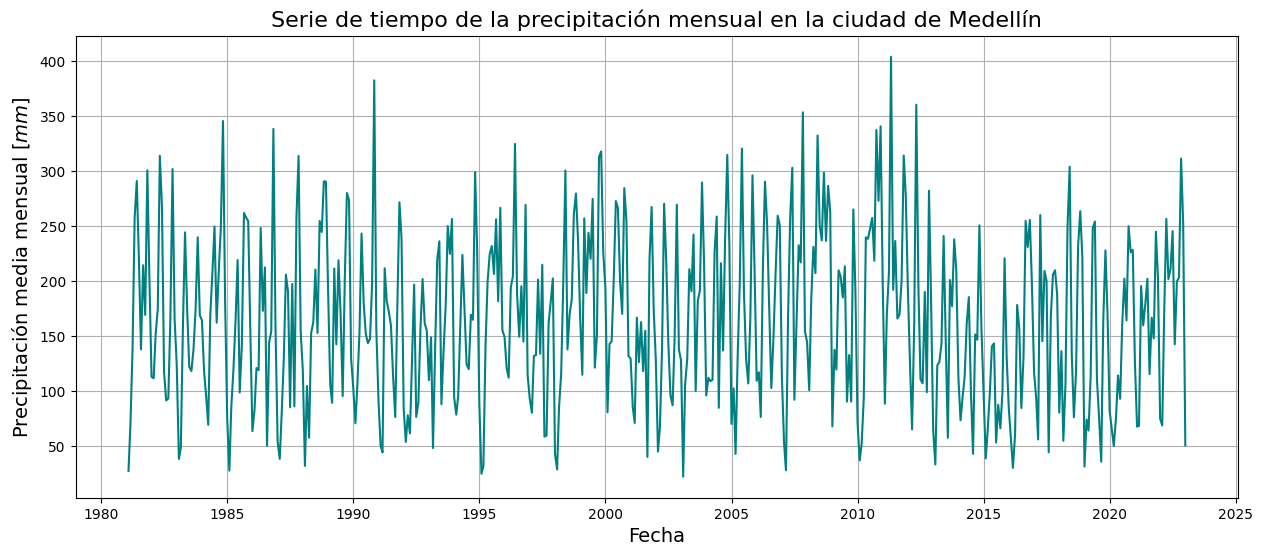

In [15]:
# Serie de tiempo de la precipitación media mensual en el pixel correspondiente a las coordenadas de Medellín, a manera de ejemplo
# Filtrar los datos del píxel específico
lat_target = 6.246205
lon_target = -75.576434

# Seleccionar los datos de precipitación para el píxel objetivo
pcp_pixel = pcp_monthly1.sel(latitude=lat_target, longitude=lon_target, method='nearest')

# Extraer los valores de tiempo y precipitación
time_values = pcp_pixel['time'].values
precipitation_values = pcp_pixel['precip'].values

# Crear un gráfico de la serie de tiempo de precipitación
plt.figure(figsize=(15, 6))  # Ajusta el ancho de la figura
plt.plot(time_values, precipitation_values, color='teal', linestyle='-')
plt.title(f'Serie de tiempo de la precipitación mensual en la ciudad de Medellín', fontsize=16)
plt.xlabel('Fecha', fontsize=14)  # Ajusta el tamaño del título del eje x
plt.ylabel('Precipitación media mensual $[mm]$', fontsize=14)  # Ajusta el tamaño del título del eje y
plt.grid()
plt.show()

### Ciclo anual promedio de precipitación

In [25]:
# Calcular el ciclo anual promedio de precipitación, que corresponde a una matriz por cada mes del año (12 meses).
pcp_annual_cycle = pcp_monthly1['precip'].groupby('time.month').mean()

#Mostrar los datos de precipitación mensual acumulada.
pcp_annual_cycle

<xarray.DataArray 'precip' (month: 12, latitude: 400, longitude: 300)>
dask.array<stack, shape=(12, 400, 300), dtype=float32, chunksize=(1, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -79.98 -79.93 -79.88 ... -65.13 -65.08 -65.03
  * latitude   (latitude) float32 -4.975 -4.925 -4.875 ... 14.88 14.92 14.97
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
# Guardar los datos del ciclo anual promedio de precipitación en un archivo NetCDF en la ubicación especificada.
#pcp_annual_cycle.to_netcdf('C:\\Users\\50646\\Manuela\\Complementariedad\\ArchivosTransformados\\pcp_annual_cycle.nc')


In [27]:
#En ninguna región de Colombia, NO llueve durante un mes, por tal razón los valores iguales a cero se convierten a NaN
pcp_annual_cycle = pcp_annual_cycle.where(pcp_annual_cycle != 0, np.nan)

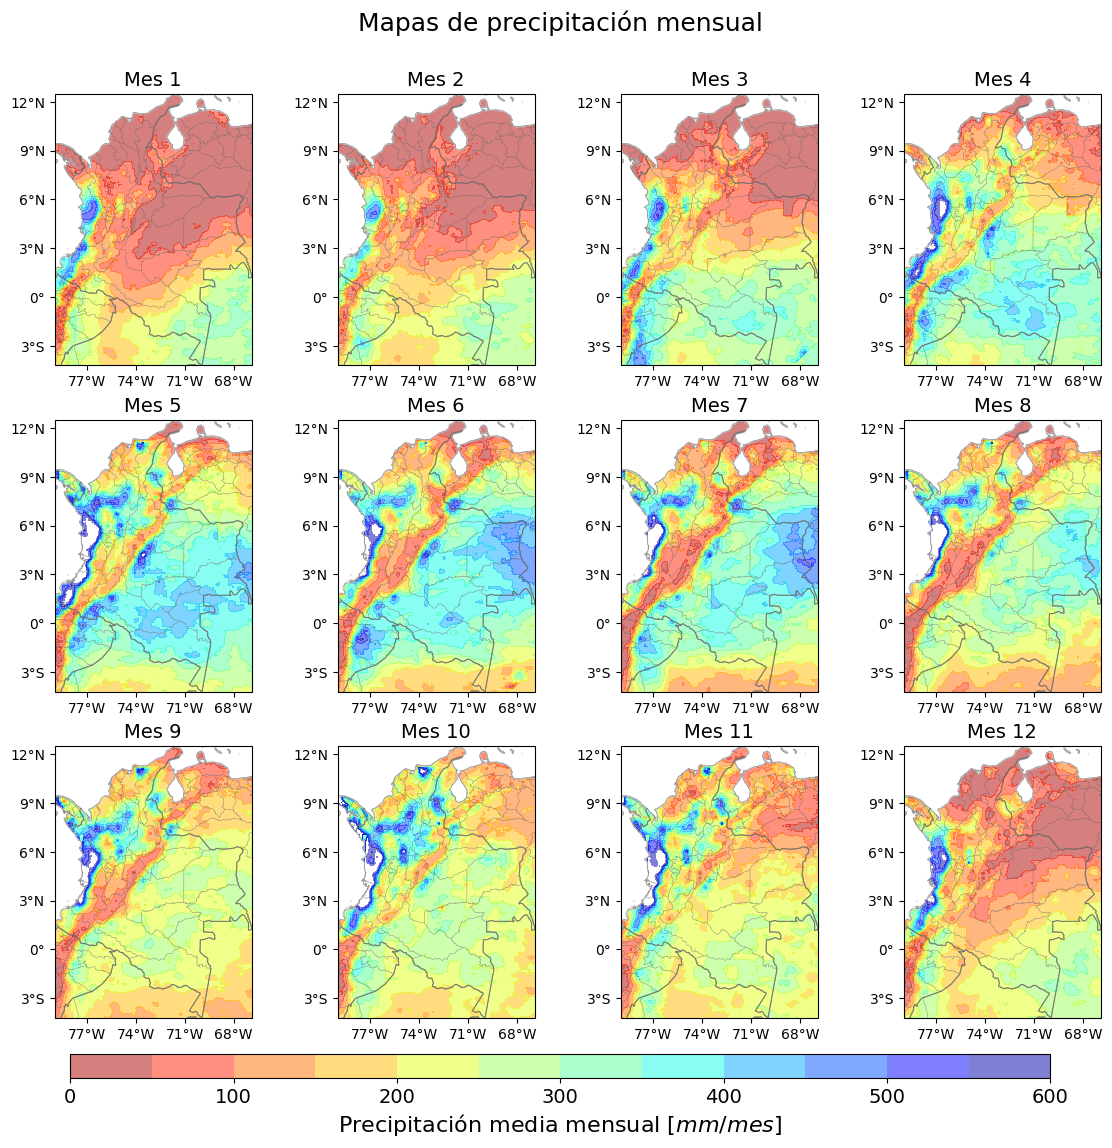

In [28]:
# Datos
lat = lat_values_CHIRPS
lon = lon_values_CHIRPS
TituloEje = 'Precipitación media mensual $[mm/mes]$'

# Definición de niveles de contorno
cmap1 = 'jet_r'
alpha1 = 0.5

# Crear figura y ejes con subplots de 4 filas y 3 columnas
fig, axs = plt.subplots(3, 4, figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Mapas de precipitación mensual', fontsize=18, y=0.95)

# Configuración de ejes y formato de etiquetas
a, b = 3, -3
xticks = np.arange(np.round(lon[0], 0), np.round(lon[-1] + a, 0) - a, a)
yticks = np.arange(np.round(lat[-1], 0) + b, np.round(lat[0], 0), b)
clevs=np.arange(0,650,50)
for i, ax in enumerate(axs.flat):
    # Mes actual (de 1 a 12)
    month = i + 1

    # Contorno de datos para el mes actual
    cs = ax.contourf(lon, lat, pcp_annual_cycle.sel(month=month).values, clevs,cmap=cmap1, alpha=alpha1)

    # Título del subplot
    ax.set_title(f'Mes {month}', fontsize=14)

    # Configuración de ejes y formato de etiquetas
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f'))

    # Configuración de los límites geográficos en un subplot específico
    ax.set_extent([-79, -66.9, -4.2, 12.5], crs=ccrs.PlateCarree())

    # Agregar características geográficas
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
    shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    ax.add_geometries(reader.geometries(), crs=ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='None', edgecolor='dimgray', linewidths=0.8, alpha=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='dimgray', alpha=0.7, linewidth=0.2)

# Añadir una barra de colores común a todos los subplots
cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.02])  # Posición de la barra de colores
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label=TituloEje, fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Ajustar el espaciado entre subplots y la figura
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Precipitación anual acumulada

In [30]:
# Sumar los valores para obtener la precipitación anual acumulada
pcp_annual = pcp_annual_cycle.sum(axis=0)

#Mostrar los datos de precipitación anual acumulada.
pcp_annual

<xarray.DataArray 'precip' (latitude: 400, longitude: 300)>
dask.array<sum-aggregate, shape=(400, 300), dtype=float32, chunksize=(400, 300), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -79.98 -79.93 -79.88 ... -65.13 -65.08 -65.03
  * latitude   (latitude) float32 -4.975 -4.925 -4.875 ... 14.88 14.92 14.97

In [ ]:
# Guardar los datos de precipitación anual acumulada en un archivo NetCDF en la ubicación especificada.
# pcp_annual.to_netcdf('C:\\Users\\50646\\Manuela\\Complementariedad\\ArchivosTransformados\\pcp_annual.nc')


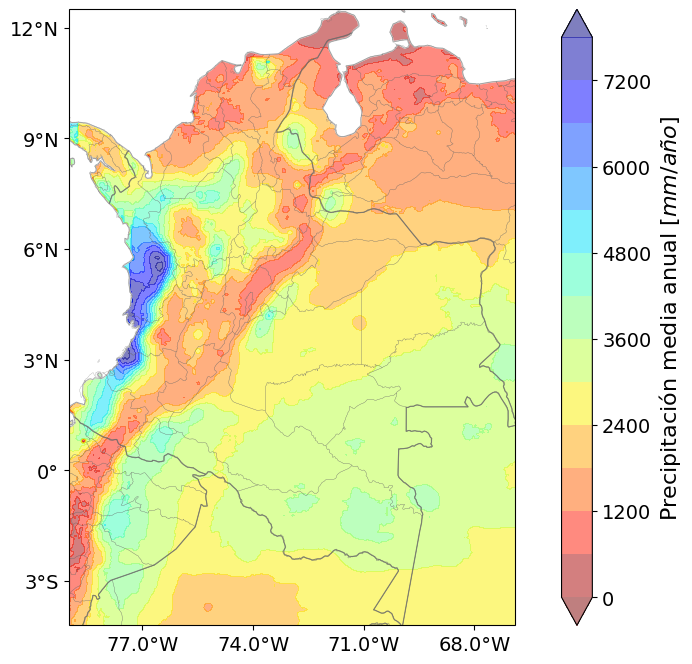

In [32]:
# Datos
Mapa = pcp_annual.values
lat = lat_values_CHIRPS
lon = lon_values_CHIRPS
TituloEje = 'Precipitación media anual $[mm/año]$'

# Definición de niveles de contorno
clevs = np.arange(myround(np.nanmin(Mapa), base=100), myround(np.nanmax(Mapa), base=100), 600)
cmap1 = 'jet_r'
alpha1 = 0.5

# Crear figura y ejes
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0, globe=None))

# Contorno de datos
cs = plt.contourf(lon, lat, Mapa, clevs, transform=ccrs.PlateCarree(), extend='both', cmap=cmap1, alpha=alpha1)

# Colorbar
cb = plt.colorbar(cs, ax=ax, orientation='vertical', shrink=1, pad=0.04)
cb.set_label(label=TituloEje, fontsize=16)
cb.ax.tick_params(labelsize=14)

# Configuración de ejes y formato de etiquetas
a, b = 3, -3
xticks = np.arange(np.round(lon[0], 0), np.round(lon[-1] + a, 0) - a, a)
yticks = np.arange(np.round(lat[-1], 0) + b, np.round(lat[0], 0), b)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.1f'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f'))

# Configuración del mapa usando la función setup_map
setup_map(ax)
plt.show()

## Radiación global horizontal (GHI, por sus siglas en inglés)

In [33]:
# Especifica la ruta y la máscara de los archivos NetCDF que se abrirán
ncfiles = "/content/local/DatosCrudos/GHI_Wind/COL_*"

# Abre y combina múltiples archivos NetCDF en un solo conjunto de datos usando xarray
ds = xr.open_mfdataset(ncfiles)

# ds es un objeto xarray.Dataset. Que contiene datos multidimensionales, con dimensiones de latitud, longitud y tiempo,
# y variables climaticas y los atributos que proporcionan información adicional sobre los datos y su origen.
ds

<xarray.Dataset>
Dimensions:    (longitude: 61, latitude: 81, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 1981-01-01 ... 1981-02-28T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
    u100       (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
    v100       (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 61), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-25 20:27:05 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [34]:
# Copiar los datos de la variable 'ssrd', generando una matriz tridimensional con 350640 registros de tiempo
# (horarios desde 1981 hasta 2020), en una región de estudio dividida en pixeles de tamaño 0.25° x 0.25°,
# lo que resulta en una resolución de 61 longitudes y 81 latitudes.
ghi = ds.copy()['ssrd']

# Ajusta las coordenadas de tiempo al tiempo local (UTC-5)
local_time = pd.to_datetime(ghi.time.values) + datetime.timedelta(hours=-5)
ghi = ghi.assign_coords(time=local_time)

# Convierte los valores de ghi de J/m2 a W/m2 (vatios por metro cuadrado)
ghi /= 3600

# MOstrar el xarray
ghi

<xarray.DataArray 'ssrd' (time: 1416, latitude: 81, longitude: 61)>
dask.array<truediv, shape=(1416, 81, 61), dtype=float32, chunksize=(744, 81, 61), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 1980-12-31T19:00:00 ... 1981-02-28T18:00:00
Attributes:
    units:          J m**-2
    long_name:      Surface solar radiation downwards
    standard_name:  surface_downwelling_shortwave_flux_in_air

In [35]:
# Eliminar la variable ds de la memoria, liberando así el espacio que ocupaba.
del ds

### Precipitación promedio mensual

In [37]:
# Re-muestrear los datos de ghi para obtener matrices de la ghi promedio mensual (481 meses).
ghi_monthly = ghi.resample(time="1M").mean()

#Mostrar los datos de ghi promedio mensual
ghi_monthly

<xarray.DataArray 'ssrd' (time: 3, latitude: 81, longitude: 61)>
dask.array<stack, shape=(3, 81, 61), dtype=float32, chunksize=(1, 81, 61), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 1980-12-31 1981-01-31 1981-02-28
Attributes:
    units:          J m**-2
    long_name:      Surface solar radiation downwards
    standard_name:  surface_downwelling_shortwave_flux_in_air

In [38]:
# Guardar los datos de ghi promedio mensual en un archivo NetCDF en la ubicación especificada.
# ghi_monthly.to_netcdf('C:\\Users\\50646\\Manuela\\Complementariedad\\ArchivosTransformados\\ghi_monthly.nc')

In [39]:
# Eliminar la variable ghi_monthly para liberar memoria.
del ghi_monthly

# Cargar una nueva variable pcp_monthly1 a partir de un archivos NetCDF el cual
# contiene la serie mensual para la totalidad de los datos.
ghi_monthly1 = xr.open_mfdataset('/content/local/DatosTransformados/ghi_monthly.nc')

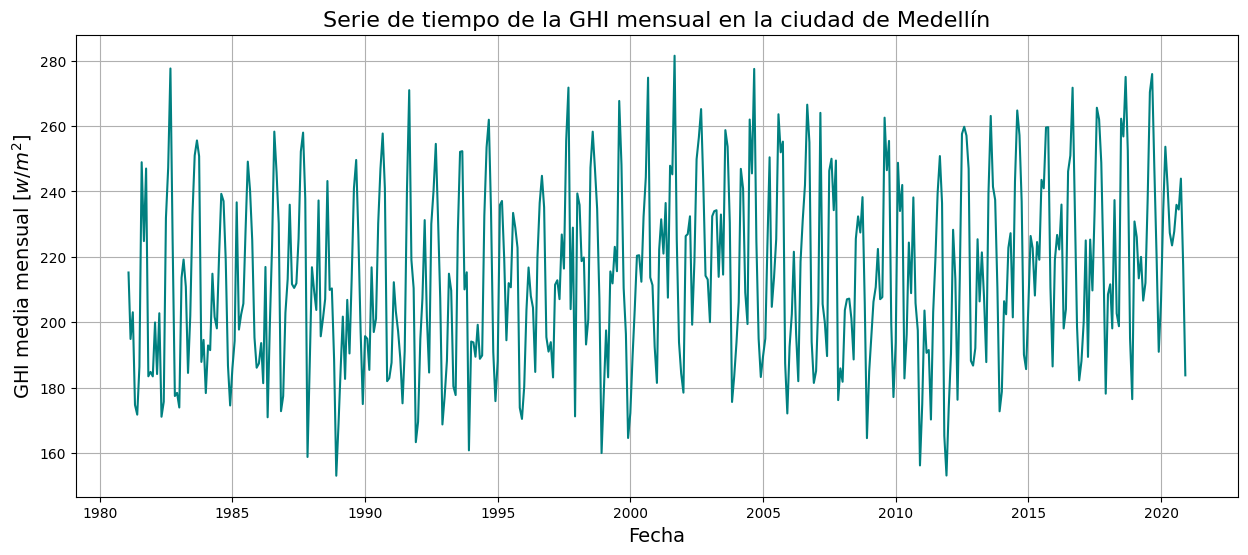

In [40]:
# Serie de tiempo de la ghi media mensual en el pixel correspondiente a las coordenadas de Medellín, a manera de ejemplo
# Filtrar los datos del píxel específico
lat_target = 6.246205
lon_target = -75.576434

# Seleccionar los datos de ghi para el píxel objetivo
ghi_pixel = ghi_monthly1.sel(latitude=lat_target, longitude=lon_target, method='nearest')

# Extraer los valores de tiempo y precipitación
time_values = ghi_pixel['time'].values
ghi_values = ghi_pixel['ssrd'].values

# Crear un gráfico de la serie de tiempo de precipitación
plt.figure(figsize=(15, 6))  # Ajusta el ancho de la figura
plt.plot(time_values[1:-1], ghi_values[1:-1], color='teal', linestyle='-')
plt.title(f'Serie de tiempo de la GHI mensual en la ciudad de Medellín', fontsize=16)
plt.xlabel('Fecha', fontsize=14)  # Ajusta el tamaño del título del eje x
plt.ylabel('GHI media mensual $[w/m^2]$', fontsize=14)  # Ajusta el tamaño del título del eje y
plt.grid()
plt.show()

### Ciclo anual promedio de Irradiacion Global Horizontal

### Ejemplo sobre una muestra de un año de la información

In [41]:
# Crear un agrupador para los datos de radiación solar global (ghi)
grouper = xr.DataArray(pd.MultiIndex.from_arrays([ghi.time.dt.month.values, ghi.time.dt.hour.values],
                       names=['month', 'hour'],), dims=['time'], coords=[ghi.time],)

# Calcular el ciclo anual promedio de radiación solar, seleccionando las horas diurnas (7 a 19)
ghi_annual_cycle = ghi.groupby(grouper).mean().sel(group_level_1=slice(7, 19)).sel(group_level_0=1).sum(axis=0) / 1000

# Iterar sobre los meses (de 2 a 12) y concatenar los resultados al ciclo anual
for i in np.arange(2, 13, 1):
    ghi_annual_cycle = xr.concat([ghi_annual_cycle, ghi.groupby(grouper).mean().sel(group_level_1=slice(7, 19)).sel(group_level_0=i).sum(axis=0) / 1000], "month")

# Resultado: Ciclo anual promedio de radiación solar global (ghi_annual_cycle) para los datos de muestra
ghi_annual_cycle

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


KeyError: ignored

In [ ]:
# Eliminar la variable ghi_annual_cycle para liberar memoria.
del ghi_annual_cycle

In [55]:
# Cargar una nueva variable ghi_annual_cycle1 a partir de un archivo NetCDF para evitar el uso
# de la versión remuestreada que consume una cantidad significativa de memoria.
ghi_annual_cycle1 = xr.open_mfdataset('/content/local/DatosTransformados/ghi_annual_cycle.nc')

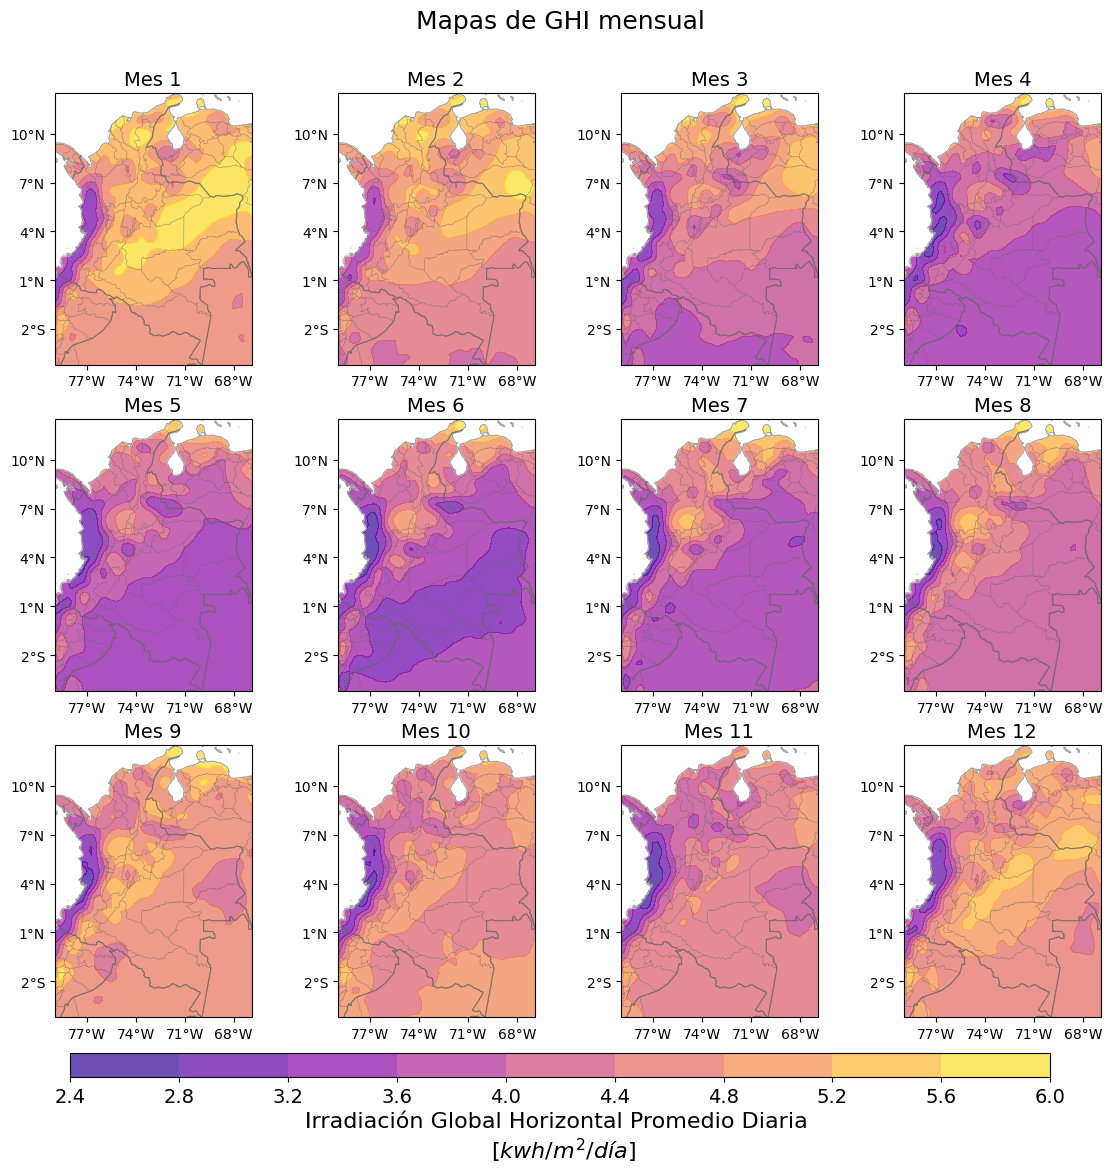

In [56]:
# Datos
lat = ghi_annual_cycle1.latitude.values
lon = ghi_annual_cycle1.longitude.values
TituloEje = f'Irradiación Global Horizontal Promedio Diaria \n $[kwh/m^2/día]$'

# Definición de niveles de contorno
cmap1 = 'plasma'
alpha1 = 0.7

# Crear figura y ejes con subplots de 4 filas y 3 columnas
fig, axs = plt.subplots(3, 4, figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Mapas de GHI mensual', fontsize=18, y=0.95)

# Configuración de ejes y formato de etiquetas
a, b = 3, 3
xticks = np.arange(np.round(lon[0], 0), np.round(lon[-1] + a, 0) - a, a)
yticks = np.arange(np.round(lat[-1], 0) + b, np.round(lat[0], 0), b)

for i, ax in enumerate(axs.flat):
    # Mes actual (de 1 a 12)
    month = i + 1

    # Contorno de datos para el mes actual
    cs = ax.contourf(lon, lat, ghi_annual_cycle1['ssrd'].sel(month=month-1).values, cmap=cmap1, alpha=alpha1)

    # Título del subplot
    ax.set_title(f'Mes {month}', fontsize=14)

    # Configuración de ejes y formato de etiquetas
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f'))

    # Configuración de los límites geográficos en un subplot específico
    ax.set_extent([-79, -66.9, -4.2, 12.5], crs=ccrs.PlateCarree())

    # Agregar características geográficas
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
    shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    ax.add_geometries(reader.geometries(), crs=ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='None', edgecolor='dimgray', linewidths=0.8, alpha=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='dimgray', alpha=0.7, linewidth=0.2)

# Añadir una barra de colores común a todos los subplots
cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.02])  # Posición de la barra de colores
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label=TituloEje, fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Ajustar el espaciado entre subplots y la figura
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Ciclo diurno de Irradiación Global Horizontal

In [ ]:
# Calcula el ciclo diurno de ghi promedio agrupado por hora del día
ghi_cyclediurne = ghi.groupby('time.hour').mean()

# Guardar los datos del ciclo diurno de GHI en un archivo NetCDF en la ubicación especificada.
ghi_cyclediurne.to_netcdf('C:\\Users\\50646\\Manuela\\Complementariedad\\ArchivosTransformados\\ghi_cyclediurne.nc')

#Mostrar los datos del ciclo diurno de GHI.
ghi_cyclediurne

<xarray.DataArray 'ssrd' (hour: 24, latitude: 81, longitude: 61)>
dask.array<stack, shape=(24, 81, 61), dtype=float32, chunksize=(1, 81, 61), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -4.5 -4.75 -5.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23

In [ ]:
# Eliminar la variable pcp_monthly para liberar memoria.
del ghi_cyclediurne

In [45]:
# Cargar una nueva variable ghi_cyclediurne1 a partir de un archivo NetCDF para tener la variablidad del periodo de tiempo completo
ghi_cyclediurne1 = xr.open_mfdataset('/content/local/DatosTransformados/ghi_cyclediurne.nc')

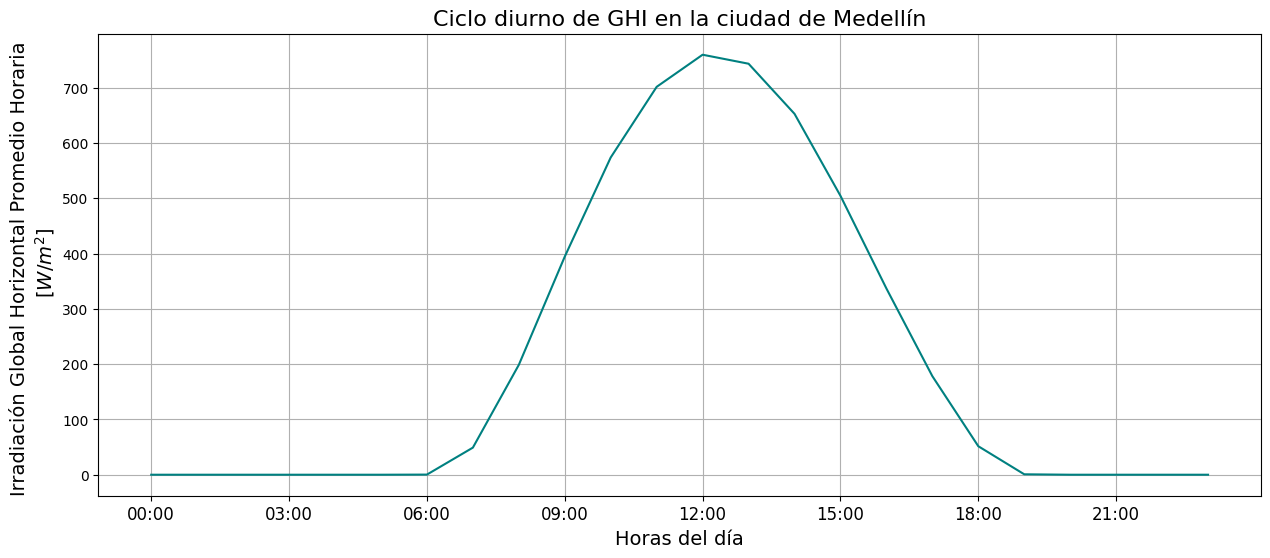

In [46]:
# Ciclo diurno de ghi en el pixel correspondiente a las coordenadas de Medellín, a manera de ejemplo
# Filtrar los datos del píxel específico
lat_target = 6.246205
lon_target = -75.576434

# Seleccionar los datos de GHI para el píxel objetivo
ghi_pixel = ghi_cyclediurne1.sel(latitude=lat_target, longitude=lon_target, method='nearest')

# Extraer los valores de tiempo y GHI
time_values = ghi_pixel['hour'].values
ghi_values = ghi_pixel['ssrd'].values

# Convertir las horas a formato de fecha en horario militar (HH:MM)
time_values = pd.to_datetime(time_values, format='%H').strftime('%H:%M')

# Crear un gráfico de la serie de tiempo de GHI
plt.figure(figsize=(15, 6))  # Ajusta el ancho de la figura
plt.plot(time_values, ghi_values, color='teal', linestyle='-')
plt.title(f'Ciclo diurno de GHI en la ciudad de Medellín', fontsize=16)
plt.xlabel('Horas del día', fontsize=14)  # Ajusta el tamaño del título del eje x
plt.ylabel('Irradiación Global Horizontal Promedio Horaria \n $[W/m^2]$', fontsize=14)  # Ajusta el tamaño del título del eje y
plt.xticks(np.arange(0, len(time_values), 3), ha='center', fontsize=12)  # Configura los ticks cada 3 horas
plt.grid()
plt.show()

### Irradiación Global Horizontal Promedio Diaria

In [50]:
# Sumar los valores del ciclo diurno en las horas diurnas (7 a 19) para obtener la radiación promedio diaria de largo plazo.
# El valor acumulado DIARIO de radiación es mundialmente usado. A diferencia del acumulado ANUAL en la precipitación.
ghi_value_day = ghi_cyclediurne1['ssrd'].interp(longitude=ghi_cyclediurne1['ssrd'].longitude.values,
                                       latitude=ghi_cyclediurne1['ssrd'].latitude.values).sel(hour=slice(7, 19)).sum(axis=0) / 1000  # Wh/m2/día

#Mostrar los datos de ghi diaria acumulada de largo plazo.
ghi_value_day

<xarray.DataArray 'ssrd' (latitude: 81, longitude: 61)>
dask.array<truediv, shape=(81, 61), dtype=float32, chunksize=(81, 61), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -4.5 -4.75 -5.0

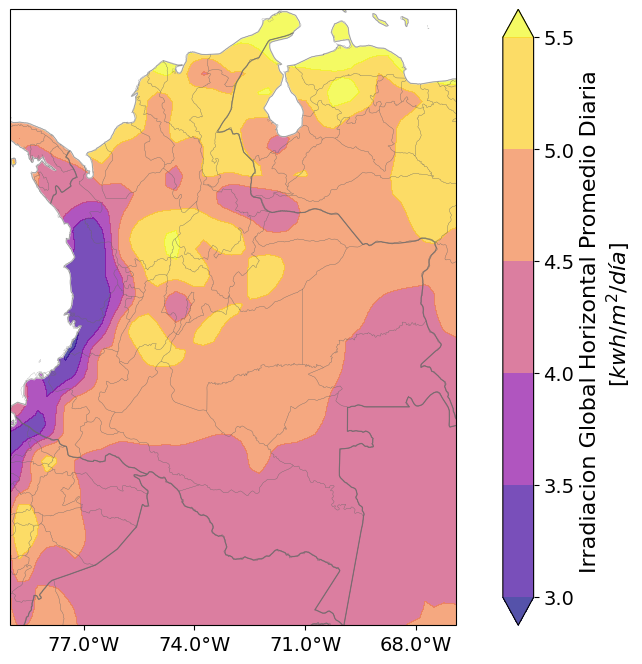

In [54]:
# Datos
Mapa = ghi_value_day.values
lat = ghi_value_day.latitude.values
lon = ghi_value_day.longitude.values
TituloEje = f'Irradiacion Global Horizontal Promedio Diaria \n $[kwh/m^2/día]$'


# Definición de niveles de contorno
clevs = np.arange(myround(np.nanmin(Mapa), base=1), myround(np.nanmax(Mapa), base=1), 0.5)
cmap1 = 'plasma'
alpha1 = 0.7

# Crear figura y ejes
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0, globe=None))

# Contorno de datos
cs = plt.contourf(lon, lat, Mapa, clevs, transform=ccrs.PlateCarree(), extend='both', cmap=cmap1, alpha=alpha1)

# Colorbar
cb = plt.colorbar(cs, ax=ax, orientation='vertical', shrink=1, pad=0.04)
cb.set_label(label=TituloEje, fontsize=16)
cb.ax.tick_params(labelsize=14)

# Configuración de ejes y formato de etiquetas
a, b = 3, -3
xticks = np.arange(np.round(lon[0], 0), np.round(lon[-1] + a, 0) - a, a)
yticks = np.arange(np.round(lat[-1], 0) + b, np.round(lat[0], 0), b)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.1f'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f'))

# Configuración del mapa usando la función setup_map
setup_map(ax)
plt.show()

## Índice Oceánico de El Niño (ONI)

In [43]:
oni_df=pd.read_excel(r"/content/local/DatosCrudos/ONI.xlsx")
mapeo = {'DJF': 1,'JFM': 2,'FMA': 3,'MAM': 4,'AMJ': 5,'MJJ': 6,'JJA': 7,'JAS': 8,'ASO': 9,'SON': 10,'OND': 11,'NDJ': 12}
# Usa la función map para realizar el mapeo
oni_df['Month'] = oni_df['SEAS'].map(mapeo)
# Combina las columnas "YR" y "Month" para crear una nueva columna "fecha"
oni_df['fecha'] = pd.to_datetime(oni_df['YR'].astype(str) + oni_df['Month'].astype(str) , format='%Y%m')
oni_df.head()

,SEAS,YR,TOTAL,ANOM,Month,fecha
0,DJF,1980,27.06,0.59,1,1980-01-01
1,JFM,1980,27.13,0.46,2,1980-02-01
2,FMA,1980,27.35,0.34,3,1980-03-01
3,MAM,1980,27.70,0.38,4,1980-04-01
4,AMJ,1980,27.90,0.48,5,1980-05-01


In [44]:
oni_df.set_index("fecha", inplace=True)
oni_df1 = oni_df[["ANOM"]]
oni_df1

,ANOM
fecha,
1980-01-01,0.59
1980-02-01,0.46
1980-03-01,0.34
1980-04-01,0.38
1980-05-01,0.48
...,...
2023-04-01,0.16
2023-05-01,0.48
2023-06-01,0.77
